In [1]:
import numpy as np
import bagpipes as pipes
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.io import fits
import astropy.cosmology as cosmology
import math

In [2]:
def get_cog(rad, intens, axis_ratio=1.0):
    """Measure curve of growth."""
    # Area within each aperture
    assert rad.shape == intens.shape
    aper_area = np.pi * axis_ratio * (rad ** 2)
    return np.nancumsum(np.append(aper_area[0], np.diff(aper_area)) * intens)

[Extinction coefficients](https://www.legacysurvey.org/dr10/catalogs/) for the three bands

In [3]:
r_band = {'g': 3.214, 'r': 2.165, 'i': 1.592, 'z': 1.211}

In [4]:
def load_phot(ID):
    path='/Users/evrinezhang/anaconda3/envs/dap/lib/python3.9/site-packages/mangadap/data/remote/'
    row=int(ID)
    rmax = 17.074856332087442  # nsa_sga[1].data['Rmax_arc'][idx]
    hdu = fits.open(path+'IC0846-largegalaxy-1113718-ellipse.fits')
    hdap = fits.open(path+'manga-11010-12701-MAPS-SPX-MILESHC-MASTARSSP.fits.gz')
    ebv = hdap[0].header['EBVGAL']
    eps_r = np.copy(hdu[1].data['R_EPS'][0])[1]
    sga_grz=np.array([22.5 - 2.5 * np.log10(hdu[1].data['G_INTENS'][0]) - r_band['g'] * ebv,
             22.5 - 2.5 * np.log10(hdu[1].data['R_INTENS'][0]) - r_band['r'] * ebv,
             22.5 - 2.5 * np.log10(hdu[1].data['Z_INTENS'][0]) - r_band['z'] * ebv])
    sga_err=np.array([22.5 - 2.5 * np.log10(hdu[1].data['G_INTENS_ERR'][0]) - r_band['g'] * ebv,
            22.5 - 2.5 * np.log10(hdu[1].data['R_INTENS_ERR'][0]) - r_band['r'] * ebv,
            22.5 - 2.5 * np.log10(hdu[1].data['Z_INTENS_ERR'][0]) - r_band['z'] * ebv])
    sga_grz = 10 ** ((23.9 - sga_grz) / 2.5)    
    sga_err = 10 ** ((23.9 - sga_err) / 2.5)
    dx = hdu[1].data['R_SMA'][0] * 0.263
    row = np.sum(1 * (dx <= rmax))
    flux = np.array([get_cog(dx / 0.263, sga_grz[0], axis_ratio=1 - eps_r) * 0.263 ** 2,
                     get_cog(dx / 0.263, sga_grz[1], axis_ratio=1 - eps_r) * 0.263 ** 2,
                     get_cog(dx / 0.263, sga_grz[2], axis_ratio=1 - eps_r) * 0.263 ** 2])
    err = np.array([get_cog(dx / 0.263, sga_err[0], axis_ratio=1 - eps_r) * 0.263 ** 2,
                    get_cog(dx / 0.263, sga_err[1], axis_ratio=1 - eps_r) * 0.263 ** 2,
                    get_cog(dx / 0.263, sga_err[2], axis_ratio=1 - eps_r) * 0.263 ** 2])
    phot_f = flux[:,row]
    phot_e = err[:,row]
    photometry = np.c_[phot_f, phot_e]
    return photometry

In [5]:
goodss_filt_list = np.loadtxt("filters/goodss_filt_list2.txt", dtype="str")

In [6]:
galaxy = pipes.galaxy('200', load_phot, spectrum_exists=False, filt_list=goodss_filt_list)

/var/folders/cd/b14jxcv1623c49mdlsjf5gj80000gn/T/ipykernel_53212/1895354584.py:9: RuntimeWarning: invalid value encountered in log10
  sga_grz=np.array([22.5 - 2.5 * np.log10(hdu[1].data['G_INTENS'][0]) - r_band['g'] * ebv,
/var/folders/cd/b14jxcv1623c49mdlsjf5gj80000gn/T/ipykernel_53212/1895354584.py:10: RuntimeWarning: invalid value encountered in log10
  22.5 - 2.5 * np.log10(hdu[1].data['R_INTENS'][0]) - r_band['r'] * ebv,
/var/folders/cd/b14jxcv1623c49mdlsjf5gj80000gn/T/ipykernel_53212/1895354584.py:11: RuntimeWarning: invalid value encountered in log10
  22.5 - 2.5 * np.log10(hdu[1].data['Z_INTENS'][0]) - r_band['z'] * ebv])
/var/folders/cd/b14jxcv1623c49mdlsjf5gj80000gn/T/ipykernel_53212/1895354584.py:12: RuntimeWarning: divide by zero encountered in log10
  sga_err=np.array([22.5 - 2.5 * np.log10(hdu[1].data['G_INTENS_ERR'][0]) - r_band['g'] * ebv,
/var/folders/cd/b14jxcv1623c49mdlsjf5gj80000gn/T/ipykernel_53212/1895354584.py:13: RuntimeWarning: divide by zero encountered in lo

# Construct fit instructions

In [7]:
delayed = {"age": (0.1, 15.),
           "tau": (0.01, 5.),
           "massformed": (7., 15.),
           "metallicity": (0., 2.5)}

In [8]:
dust = {"type": "Calzetti", "Av": (0., 2.)}

In [9]:
fit_info = {"redshift": (0,2), "redshift_prior": "Gaussian", "redshift_prior_mu": 0.02,
            "redshift_prior_sigma": 0.02}

In [10]:
fit_info["delayed"] = delayed
fit_info["dust"] = dust
fit_info["veldisp"] = (0.500)

In [12]:
fit = pipes.fit(galaxy, fit_info)

# Fitting

In [13]:
fit.fit(verbose=False)


Bagpipes: fitting object 200

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    6
 *****************************************************
 ln(ev)=   95.789825763527887      +/-  0.15720338535634276     
 Total Likelihood Evaluations:        37798

Completed in 138.9 seconds.

 Sampling finished. Exiting MultiNest
Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
delayed:age                    6.282      9.517     11.916
delayed:massformed            10.931     11.228     11.508
delayed:metallicity            0.220      0.517      1.011
delayed:tau                    0.314      0.820      1.451
dust:Av                        0.100      0.317      0.744
redshift                

/Users/evrinezhang/anaconda3/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/Users/evrinezhang/anaconda3/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.log10(self.sfr*self.age_of_universe) - self.formed_mass


# Plots

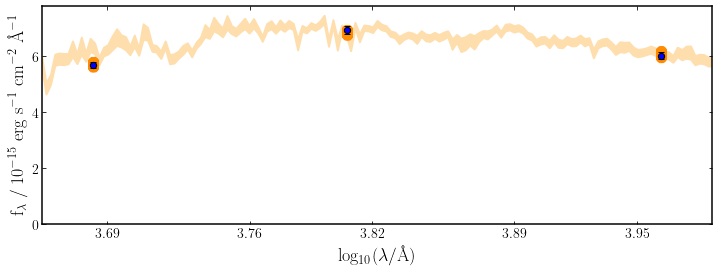

(<Figure size 864x288 with 1 Axes>,
 [<AxesSubplot:xlabel='$\\mathrm{log_{10}}\\big(\\lambda / \\mathrm{\\AA}\\big)$', ylabel='$\\mathrm{f_{\\lambda}}\\ \\mathrm{/\\ 10^{-15}\\ erg\\ s^{-1}\\ cm^{-2}\\ \\AA^{-1}}$'>])

In [14]:
fit.plot_spectrum_posterior(save=False, show=True)

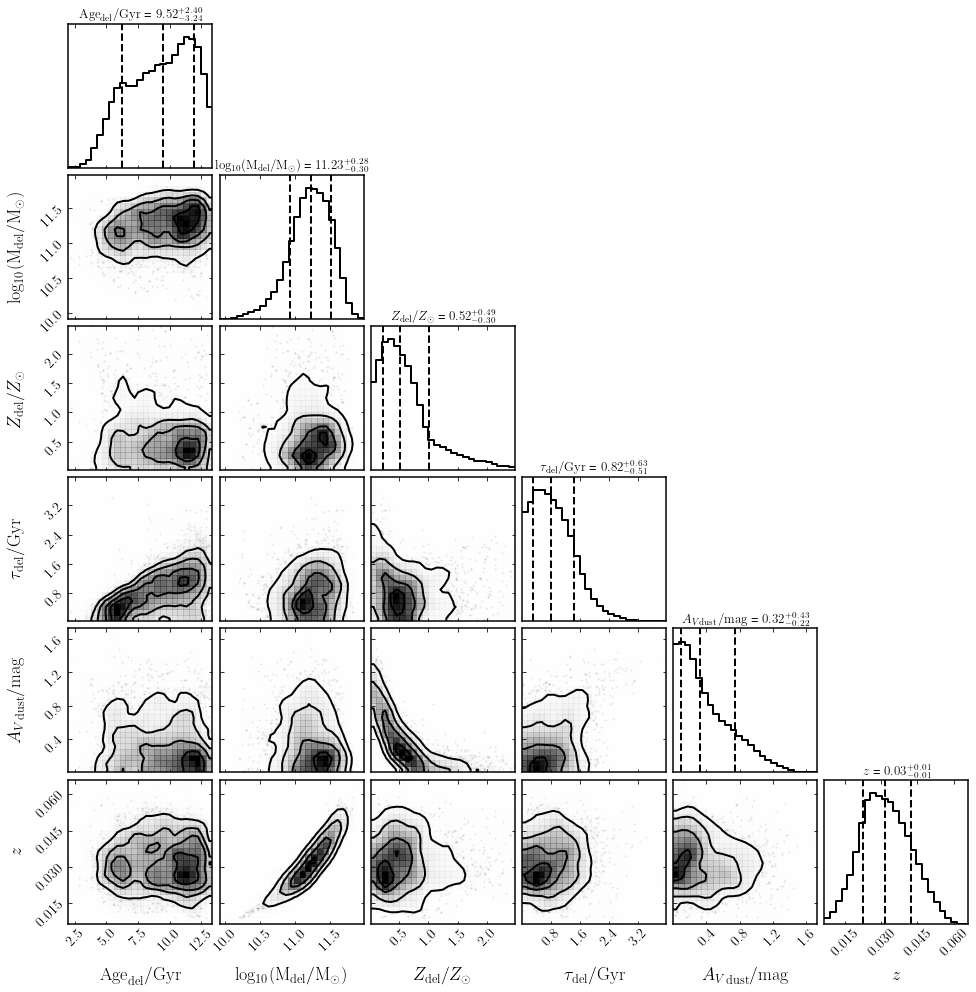

In [15]:
fig=fit.plot_corner(show=True,save=False)